In [1]:
import pandas as pd
canciones = pd.read_csv("competition_data.csv")
print(f'cantidad de filas: {canciones.shape[0]}')
print(f'cantidad de columnas: {canciones.shape[1]}')
cant_nan = (canciones.isnull().sum().sum()/(canciones.shape[0]*canciones.shape[1]))*100
print(f"Total de valores faltantes en el dataset: {round(cant_nan,2)} %")
#balanceados los datos?

porcentaje_false = ((canciones[canciones["TARGET"]==0]).shape[0]/canciones.shape[0])*100
print(f"Porcentje de falsos: {porcentaje_false} %")
print(f"Cantidad de valores faltanes por columna: {canciones.isnull().sum()}")

cantidad de filas: 100144
cantidad de columnas: 13
Total de valores faltantes en el dataset: 1.56 %
Porcentje de falsos: 47.32385365074293 %
Cantidad de valores faltanes por columna: Unnamed: 0                               0
ts                                       0
username                                 0
platform                                 0
conn_country                             0
user_agent_decrypted                 16397
master_metadata_track_name             973
master_metadata_album_artist_name      973
master_metadata_album_album_name       973
spotify_track_uri                      973
reason_start                             4
shuffle                                  0
TARGET                                   0
dtype: int64


In [2]:

# Definir las columnas a verificar
columnas_objetivo = [
    "master_metadata_track_name",
    "master_metadata_album_artist_name",
    "master_metadata_album_album_name"
]

# Filtrar filas donde las tres columnas sean NaN
filas_faltantes = canciones[canciones[columnas_objetivo].isnull().all(axis=1)]

# Seleccionar solo las columnas deseadas (las tres columnas + user_id)
columnas_a_mostrar = columnas_objetivo + ["username"]
resultado = filas_faltantes[columnas_a_mostrar]

# Mostrar resultados
#print(resultado)
#print(f"Cantidad de filas donde faltan los tres atributos: {resultado.shape[0]}")
#print(canciones.dtypes)



In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


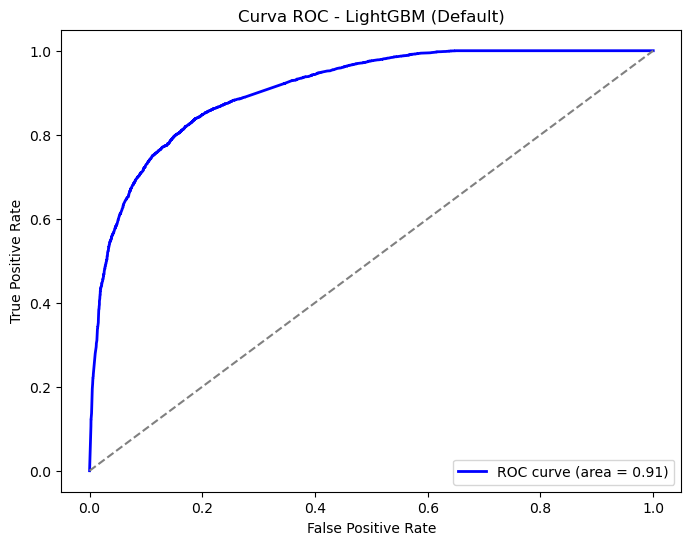

AUC-ROC: 0.9085


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
########PREPARACION DE DATOS

# Convertir columnas categóricas
categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted",
    "master_metadata_track_name", "master_metadata_album_artist_name",
    "master_metadata_album_album_name", "reason_start"
]


for col in categorical_cols:
    canciones[col] = canciones[col].astype("category")

# Convertir fechas
canciones["ts"] = pd.to_datetime(canciones["ts"], utc=True).view("int64") / 10**9


# Eliminar "spotify_track_uri" si no es relevante (parece un identificador único)
if "spotify_track_uri" in canciones.columns:
    canciones = canciones.drop(columns=["spotify_track_uri"])

canciones.columns = (
    canciones.columns
    .str.replace(r"[^\w]", "_", regex=True)  # Reemplaza cualquier carácter no alfanumérico por "_"
    .str.lower()  # Convierte los nombres a minúsculas
)

########MODELO
# Separar variables predictoras (X) y target (y)
y = canciones["target"]
X = canciones.drop(columns=["target"])  


# Primera división: 70% Train, 30% (que luego se dividirá en valid y test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Segunda división: dividir el 30% restante en 15% validación y 15% test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) #cheqiuear qwue es stratify (NO SE SABE SI ESTA BIENE ESTO!!!!!)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
val_data = lgb.Dataset(X_valid, label=y_valid)


params_lgb = {
    'num_leaves': 2**10,  # Relacionado con la profundidad, ajusta si sigue sobreajustando
    'learning_rate': 0.1, 
    'max_depth': 10,  # Equivalente a 'depth' en CatBoost
    'objective': 'binary', 
    'metric': 'auc',
    'random_state': 42,
    'verbose': -1
}

num_round = 10
modelo = lgb.train(params_lgb, train_data, num_round, valid_sets = [val_data])

# Predecir probabilidades en el conjunto de prueba
y_pred_proba = modelo.predict(X_test)

# Calcular la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - LightGBM (Default)")
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")


In [6]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

######## PREPARACIÓN DE DATOS ########

# Convertir columnas categóricas
categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted",
    "master_metadata_track_name", "master_metadata_album_artist_name",
    "master_metadata_album_album_name", "reason_start"
]

for col in categorical_cols:
    canciones[col] = canciones[col].astype(str)

# Convertir fechas
canciones["ts"] = pd.to_datetime(canciones["ts"], utc=True).view("int64") / 10**9


# Eliminar "spotify_track_uri" si no es relevante
if "spotify_track_uri" in canciones.columns:
    canciones = canciones.drop(columns=["spotify_track_uri"])

# Normalizar nombres de columnas
canciones.columns = (
    canciones.columns
    .str.replace(r"[^\w]", "_", regex=True)
    .str.lower()
)

######## MODELO ########
y = canciones["target"]          # target: lo que quiero predecir
X = canciones.drop(columns=["target"])  # features: todo lo demás

''' # esto es lo viejo de la división.
# Dividir en conjunto de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Configurar el dataset para CatBoost
train_data = cb.Pool(X_train, label=y_train, cat_features=categorical_cols)
valid_data = cb.Pool(X_valid, label=y_valid, cat_features=categorical_cols)
'''

# Dividir en 90% entrenamiento y 10% validación
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y  # mantiene proporciones del target
)

# Crear los Pools para CatBoost
train_data = cb.Pool(X_train, label=y_train, cat_features=categorical_cols)
valid_data = cb.Pool(X_valid, label=y_valid, cat_features=categorical_cols)

'''lo de arriba es nuevo. cambié lo de la división de los datos'''

modelo = cb.CatBoostClassifier(verbose=0, loss_function='Logloss', eval_metric='AUC', random_seed=42,cat_features=categorical_cols)
# Definir parámetros del modelo
grid_params = {
    'iterations': [100, 200, 300],  # Número de iteraciones
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'depth': [4, 6, 8],  # Profundidad del árbol
    'l2_leaf_reg': [1, 3, 5, 7],  # Regularización L2
}

best_params = modelo.grid_search(grid_params, X=X_train, y=y_train, cv=3, partition_random_seed=42)


bestTest = 0.8878059205
bestIteration = 97

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8878059	best: 0.8878059 (0)	total: 2.46s	remaining: 4m 22s

bestTest = 0.9003899372
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9003899	best: 0.9003899 (1)	total: 4.82s	remaining: 4m 15s

bestTest = 0.9032882384
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9032882	best: 0.9032882 (2)	total: 7.05s	remaining: 4m 6s

bestTest = 0.8881086583
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8881087	best: 0.9032882 (2)	total: 9.49s	remaining: 4m 6s

bestT

{'params': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300}, 'cv_results': defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193

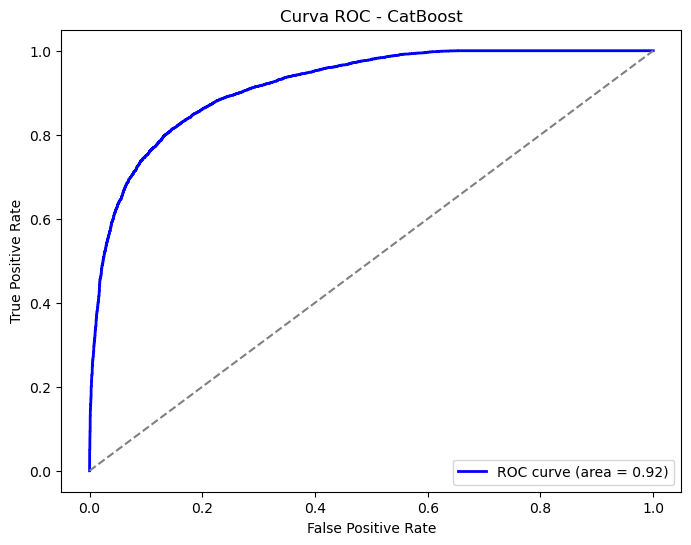

AUC-ROC: 0.9174


In [8]:
#print(best_params)
# best{'params': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300},


solo_parametros = best_params["params"]
# Entrenar el modelo

modelofinal = cb.CatBoostClassifier(**solo_parametros, cat_features=categorical_cols, verbose=100)

# Entrenar con todo el dataset de entrenamiento
modelofinal.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Probar distintos hiperparametros


# Predecir probabilidades en el conjunto de prueba
y_pred_proba = modelofinal.predict_proba(X_test)[:, 1]

# Calcular la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - CatBoost")
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")



In [ ]:
#Calcular correlaciones y target
importancia = modelofinal.get_feature_importance()
columnas = X_train.columns

df_importancia = pd.DataFrame({
    'atributo': columnas,
    'importancia': importancia
}).sort_values(by='importancia', ascending=False)

/var/folders/jc/_3wsvphd4bgdb6n9q0pwhp0c0000gp/T/ipykernel_9037/41870594.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


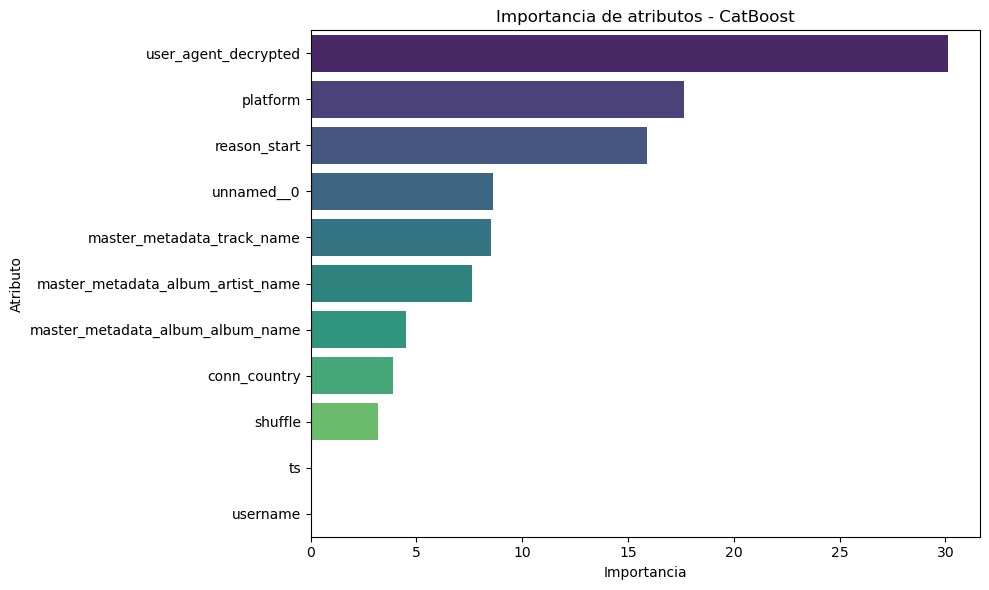

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
#Graficar correlaciones de atributos y target
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_importancia.head(20),  # Top 20 más importantes
    x='importancia', y='atributo', palette='viridis'
)
plt.title('Importancia de atributos - CatBoost')
plt.xlabel('Importancia')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()


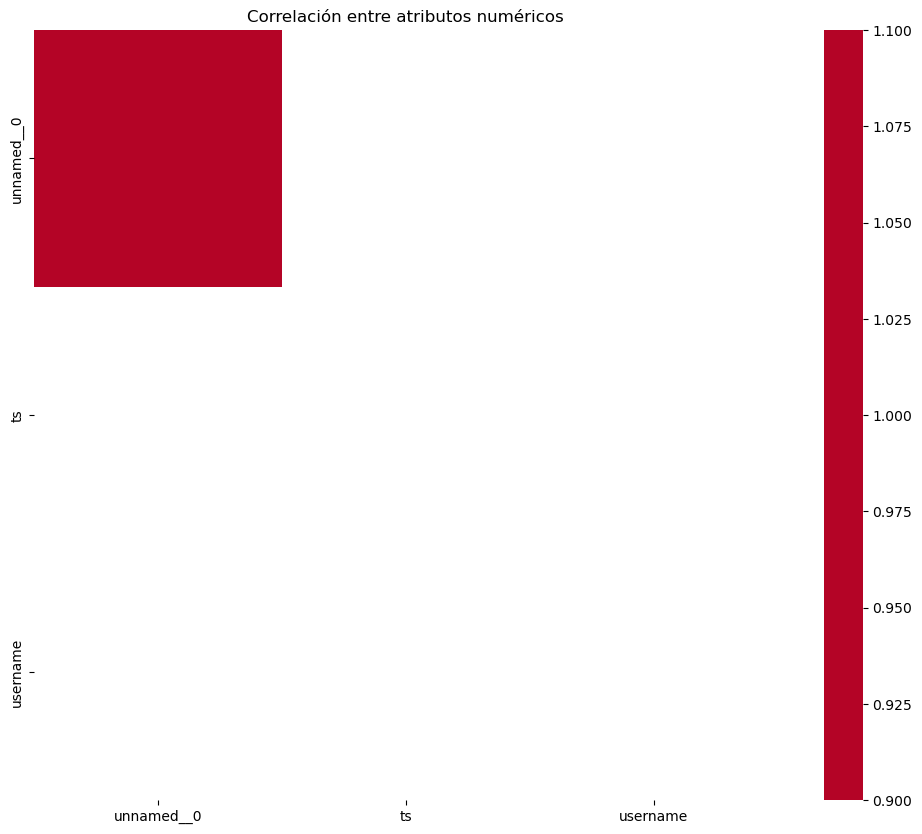

KeyError: 'tu_variable'

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# solo columnas numéricas
df_num = canciones.select_dtypes(include='number')

# matriz de correlación
corr = df_num.corr(method='pearson')  # o 'spearman'
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlación entre atributos numéricos')
plt.show()

target_feature = 'tu_variable'
df_num.corrwith(df_num[target_feature]).sort_values(ascending=False)


In [31]:
submission = pd.read_csv("submission.csv")


submission["ts"] = pd.to_datetime(submission["ts"], utc=True).view("int64") / 10**9

categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted",
    "master_metadata_track_name", "master_metadata_album_artist_name",
    "master_metadata_album_album_name", "reason_start"
]


for col in categorical_cols:
    submission[col] = submission[col].astype(str)


if "spotify_track_uri" in submission.columns:
    submission = submission.drop(columns=["spotify_track_uri"])

# Normalizar nombres de columnas
submission.columns = (
    submission.columns
    .str.replace(r"[^\w]", "_", regex=True)
    .str.lower()
)

# Predicción
df_predicciones = pd.DataFrame({
    'ID': submission.iloc[submission.index, 0],
    'TARGET': modelofinal.predict_proba(submission)[:, 1]
})


# Guardar en un archivo CSV
df_predicciones.to_csv("predicciones_catboost.csv", index=False)

print("Predicciones guardadas en 'predicciones_catboost.csv'")


Predicciones guardadas en 'predicciones_catboost.csv'
